## SHapley Additive exPlanations (SHAP)

Collational notebook of SHAP resources and code from several sources

### Contents

[1. SHAP resources and overview](#shap-resources) <br>
[2. Supervised learning with binary classification](#binary) <br>
[3. Supervised learning with multilabel classification](#multilabel) <br>
[4. Regression analysis](#regression) <br>
[5. Average shapely values](#averages)<br>
[6. Additional shap plots](#custom)<br>
[7.  GitHub repositories for interactive SHAP plots and GitHub repository references](#interactive)<br>

**Note:** <br>
Notebook is setup to run in mybinder.org (https://mybinder.org/v2/gh/hlnicholls/SHAP-reference/HEAD) which does not accept warnings, inspect, plotly, or dash packages without failing to connect - to run any interactive code theses packages need to be pip installed separately to run outside of mybinder.


# 1. SHAP resources and overview <a class="anchor" id="shap-resources"></a>

**Resources**
- https://shap.readthedocs.io/
- https://github.com/slundberg/shap
- https://christophm.github.io/interpretable-ml-book/shap.html
- https://www.investopedia.com/terms/s/shapley-value.asp

### SHAP values

The Shapley value is a solution concept (prediction of how a game is played) that is  used in game theory that involves fairly distributing both gains and costs to several actors working in coalition. Game theory is when two or more players or factors are involved in a strategy to achieve a desired outcome or payoff.

Game theory premise in ML terms:
- Game = ML prediction task
- Players/actors = each feature
- Game theory aims to measure the contribution of each player


The Shapley value is the average expected marginal contribution of one player (feature) after all possible combinations have been considered.  <br>
The Shapley value helps to determine a payoff for all of the players when each player might have contributed more or less than the others <br>
(Marginal contribution is a contribution that is made by a feature even when all other features are present -  then its importance is at least as large as the additional gain it creates)

**The big difference to LIME:** <br>
LIME weights the instances according to how close they are to the original instance. The more 0’s in the coalition vector, the smaller the weight in LIME. SHAP weights the sampled instances according to the weight the coalition would get in the Shapley value estimation. 

### Type of SHAP:
- KernelSHAP (model agnostic). 
Disadvantage note: KernelSHAP suffers from the same problem as all permutation-based interpretation methods - the estimation puts too much weight on unlikely instances.
- TreeSHAP (tree model specific). https://shap.readthedocs.io/en/latest/tabular_examples.html#tree-based-models
Disadvantage note: defines the value function using the conditional expectation as a opposed to marginal expectation - this risks a non-zero estimate even when a feature does not influence the model prediction
- DeepSHAP and GradientExplainer (deep learning specific)


### SHAP Advantages:
- SHAP has a solid theoretical foundation in game theory to come up with an explanation.
- SHAP introduces a way to connect LIME and Shapley values so that we can have a good method (KernelExplainer) to explain any model.
- SHAP can explain to an individual level, we can also aggregate the results to get a global explanation.
- SHAP has a fast implementation of tree-based models (TreeExplainer) <br>
(https://ai.plainenglish.io/understanding-shap-for-interpretable-machine-learning-35e8639d03db)

## SHAP Visualisation Options:
- Summary plot
- Decision plot
- Force plot
- Dependence plot
- Waterfall plot
- Heatmap

In [1]:
#Commented out additional packages that are not accepted by mybinder
#import warnings
#import inspect #optionality to view shap function parameters e.g.: print(inspect.getfullargspec(shap.summary_plot))
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import xgboost
import shap
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns 
seed = 42

# 2. Supervised Learning - Binary Classification <a class="anchor" id="binary"></a>

- Example dataset using rows of 243 genes by 8 features to predict most likely causal blood pressure genes (built for regression analysis and repurposed here for all ML types used in SHAP)

In [2]:
#reading in target column/dependent variable (BPlabel) and Gene names (row names) only:
data = pd.read_csv("training_cleaned.csv", header=0, usecols=["Gene","BPlabel"])

#Mapping labels to numeric values for supervised learning:
data["BPlabel_encoded"] = data["BPlabel"].map({"most likely": 1, "probable": 0, "least likely": 0})
Y = data["BPlabel_encoded"]

#reading in selected features:
X = pd.read_csv("selected_features_training_data.csv", header=0)

#Attach Gene column from data as row names for X:
df_gene = data[["Gene"]]
X = pd.concat([df_gene, X], axis=1)
X = X.set_index("Gene")

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

#Build model (Already tuned on nested cross-validation)
xgb = xgboost.XGBClassifier(
    n_estimators=46,
    learning_rate=0.1537131375248144,
    max_depth=3,
    reg_alpha=1,
    reg_lambda=1,
    random_state=seed,
    eval_metric="mlogloss",
    use_label_encoder=False)

#Fit model to training data to investigate its performance when generlaising to unseen test data
xgb.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1537131375248144,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=46, n_jobs=16,
              num_parallel_tree=1, random_state=42, reg_alpha=1, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

## Plotting Global Feature Importance:
- Overall importance for all predictions

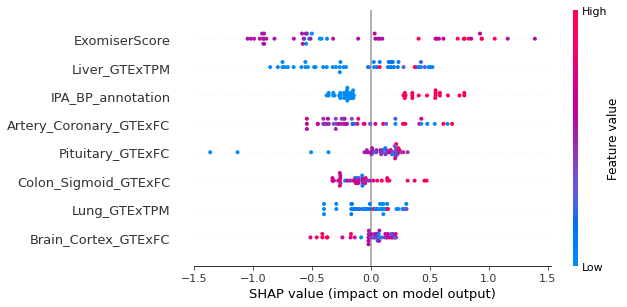

In [3]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
#beeswarm summary plot:
shap.summary_plot(shap_values, X_test)

In [4]:
#print(inspect.getfullargspec(shap.summary_plot)) #will not run in mybinder without inspect package

FullArgSpec(args=['shap_values', 'features', 'feature_names', 'max_display', 'plot_type', 'color', 'axis_color', 'title', 'alpha', 'show', 'sort', 'color_bar', 'plot_size', 'layered_violin_max_num_bins', 'class_names', 'class_inds', 'color_bar_label', 'cmap', 'auto_size_plot', 'use_log_scale'], varargs=None, varkw=None, defaults=(None, None, None, None, None, '#333333', None, 1, True, True, True, 'auto', 20, None, None, 'Feature value', <matplotlib.colors.LinearSegmentedColormap object at 0x7f89f91ed0d0>, None, False), kwonlyargs=[], kwonlydefaults=None, annotations={})


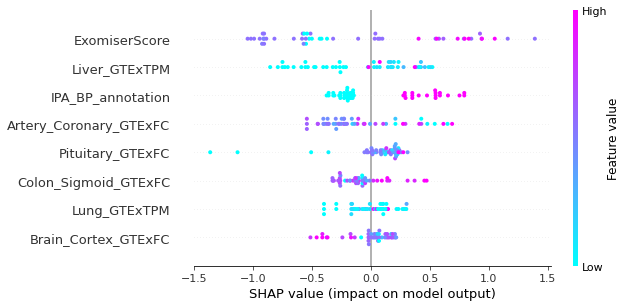

In [5]:
#https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, color=plt.get_cmap("cool"))

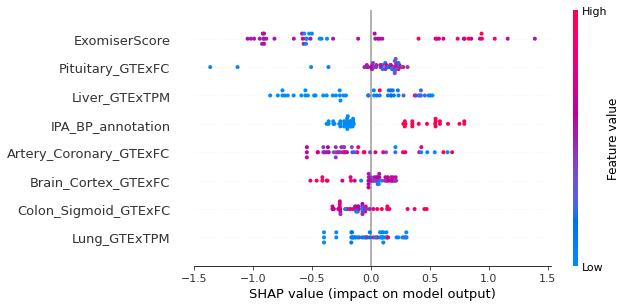

In [6]:
#reorder features (default above is absolute mean value, this is absolute max value)
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0))

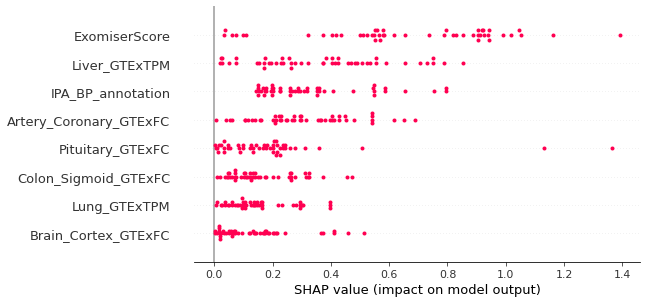

In [7]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

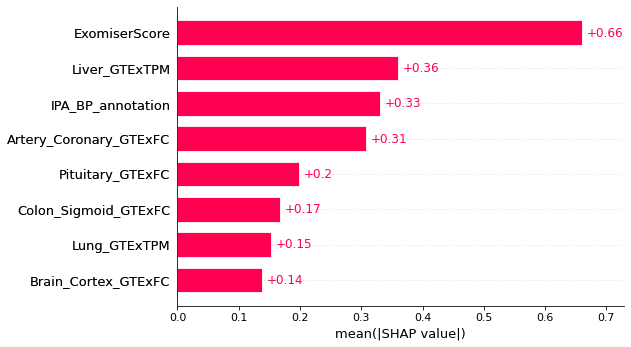

In [8]:
shap.plots.bar(shap_values.abs.mean(0))

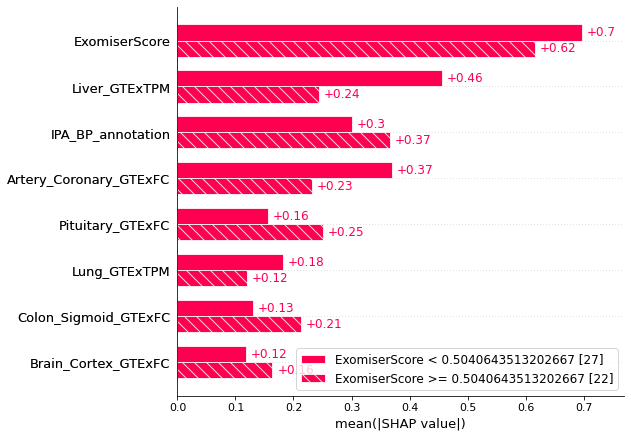

In [9]:
#https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

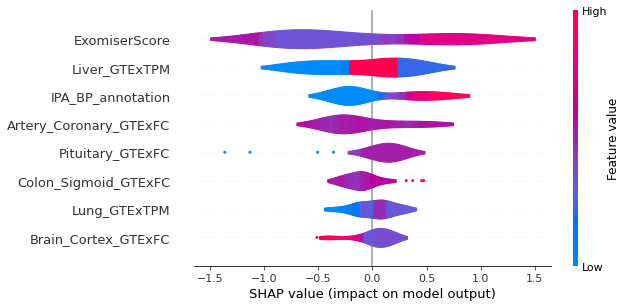

In [10]:
shap.summary_plot(shap_values, X_test, plot_type="violin", color="coolwarm")

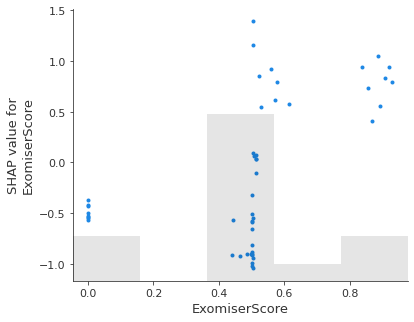

In [11]:
#https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html
shap.plots.scatter(shap_values[:,"ExomiserScore"])

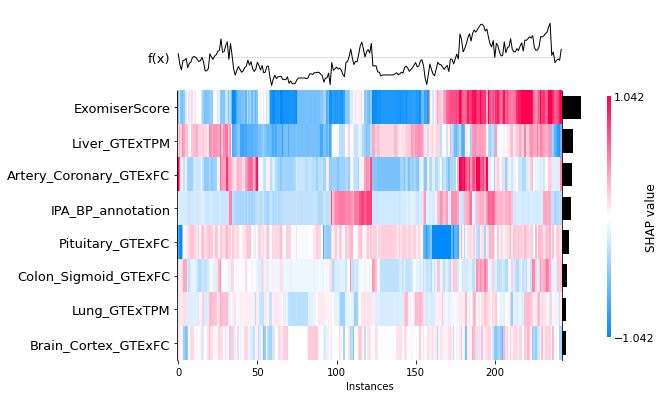

In [12]:
#Viewing SHAP interpretation for whole training dataset:
## https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/heatmap.html
shap_values = explainer(X)
fig, ax = plt.subplots()
shap.plots.heatmap(shap_values)
#fig.savefig('shap_heatmap.svg', format='svg', dpi=1200, bbox_inches = "tight")

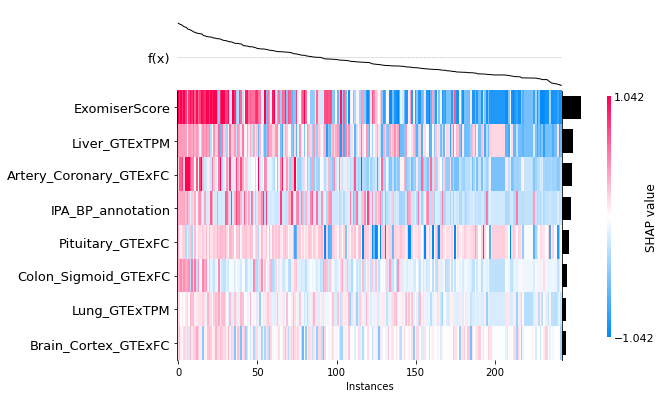

In [13]:
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1))

In [14]:
select = range(8)
features = X.iloc[select]
features_display = X.loc[features.index]

shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[:243, :].values, #by calling shap_values.values instead of just shap_values shap_values holds the shapley values, the base_values and the data
    X.iloc[:243, :],
    features_display)

In [15]:
#Save interactive force plot as HTML:
output_of_force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[:243, :].values,
    X.iloc[:243, :],
    features_display,
    show=False)
file = "force_plot.html"
#shap.save_html(file, output_of_force_plot)

### Calculate expected value 
- Expected value is the mean prediction of your model on train data (also known as the base value)

In [16]:
explainer = shap.TreeExplainer(xgb)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(8)
features = X_test.iloc[select]
features_display = X_test.loc[features.index]

#not using warnings package as it is not a package in mybinder
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
shap_values = explainer.shap_values(features)[1]
shap_interaction_values = explainer.shap_interaction_values(features)
#if isinstance(shap_interaction_values, list):
shap_interaction_values = shap_interaction_values[1]

Explainer expected value: [-1.50625568]


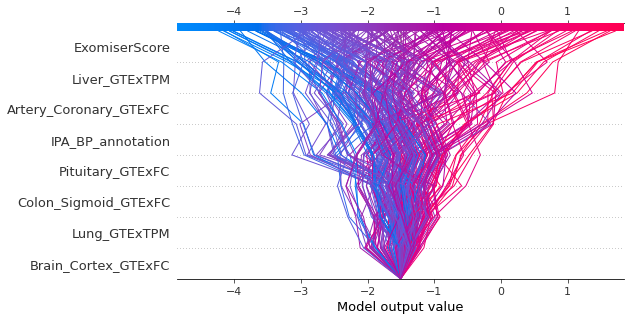

In [17]:
#Feeature interpretation for all genes 
shap.decision_plot(
    expected_value,
    explainer.shap_values(X),
    features_display,
    ignore_warnings=True)

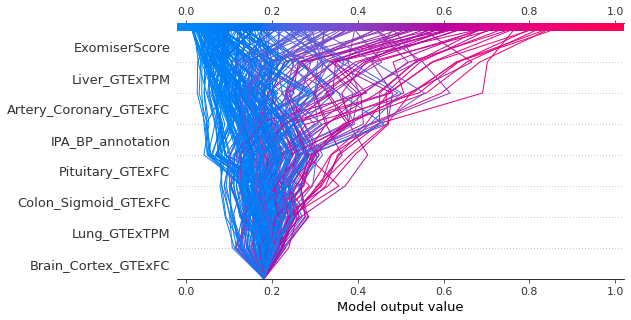

In [18]:
#Feature interpretation for all genes transforming the model output from log odds to probabilities
shap.decision_plot(
    expected_value,
    explainer.shap_values(X),
    features_display,
    ignore_warnings=True,
    link='logit')

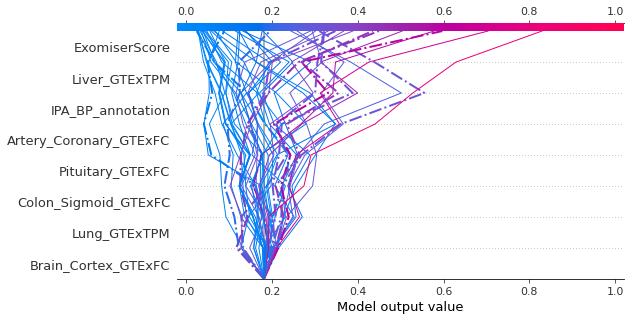

In [19]:
#Dotted lines are misclassified genes
shap_values = explainer(X_test)
y_pred = (shap_values.values.sum(1) + expected_value) > 0
y_pred= y_pred.astype(int)
misclassified = y_pred != Y_test
shap.decision_plot(expected_value, shap_values.values, features_display, link='logit', highlight=misclassified)

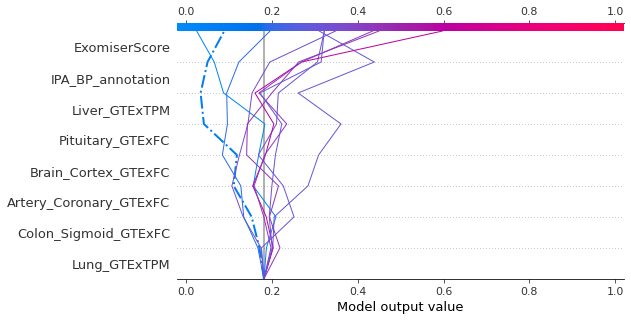

In [20]:
X_test.reset_index(drop=True, inplace=True)
features = X_test.iloc[select]
features_display = X_test.loc[features.index]

shap_val = shap_values.values
shap.decision_plot(expected_value, shap_val[misclassified], features_display, link='logit', highlight=0) #highlighting the first misclassified row/gene

## Plotting Local Feature Importance:
- Individual gene predictions

In [21]:
#Find index number of a gene to align with shap data row
list(X.index).index("ACE")

6

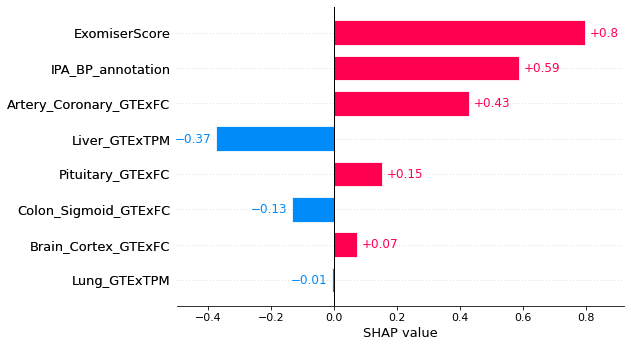

In [22]:
shap_values = explainer(X)
shap.plots.bar(shap_values[6])

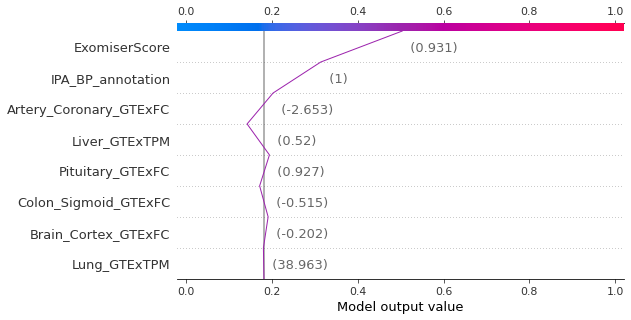

In [23]:
shap.decision_plot(
    expected_value,
    explainer.shap_values(X.iloc[[6]]),
    X.iloc[6],
    list(features_display,),
    return_objects=True,
    link='logit'
)

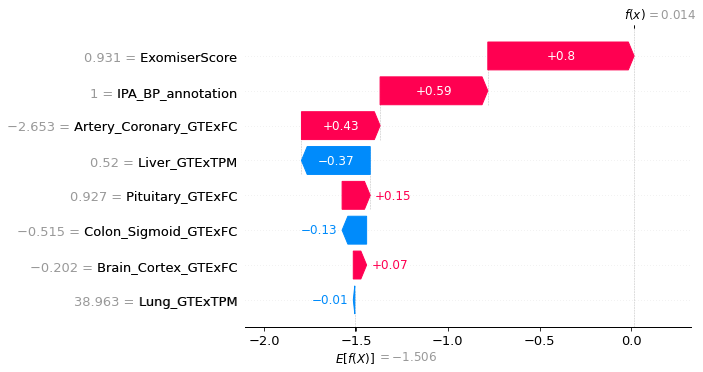

In [24]:
#https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html
shap.plots.waterfall(shap_values[6])

In [25]:
#https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
def shap_plot(j):
    explainerModel = shap.TreeExplainer(xgb)
    shap_values_Model = explainerModel.shap_values(X)
    p = shap.force_plot(
        explainerModel.expected_value,
        shap_values_Model[j],
        X.iloc[[j]],
        feature_names=X.columns
    )
    return p


shap_plot(6)

In [26]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(xgb)
    shap_values_Model = explainerModel.shap_values(X)
    p = shap.force_plot(
        explainerModel.expected_value,
        shap_values_Model[j],
        X.iloc[[j]],
        feature_names=X.columns,
        plot_cmap="PkYg" #change colour scheme
    )
    return p


shap_plot(6)

### Plotting Feature-feature interactions:

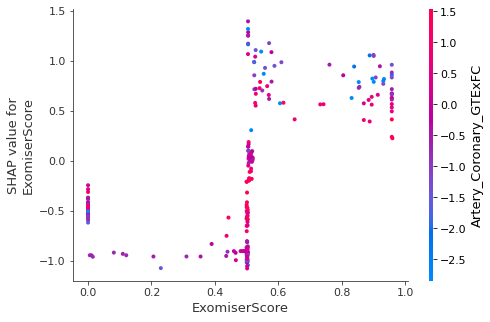

In [27]:
shap.dependence_plot("ExomiserScore", shap_values.values, X, interaction_index="Artery_Coronary_GTExFC")

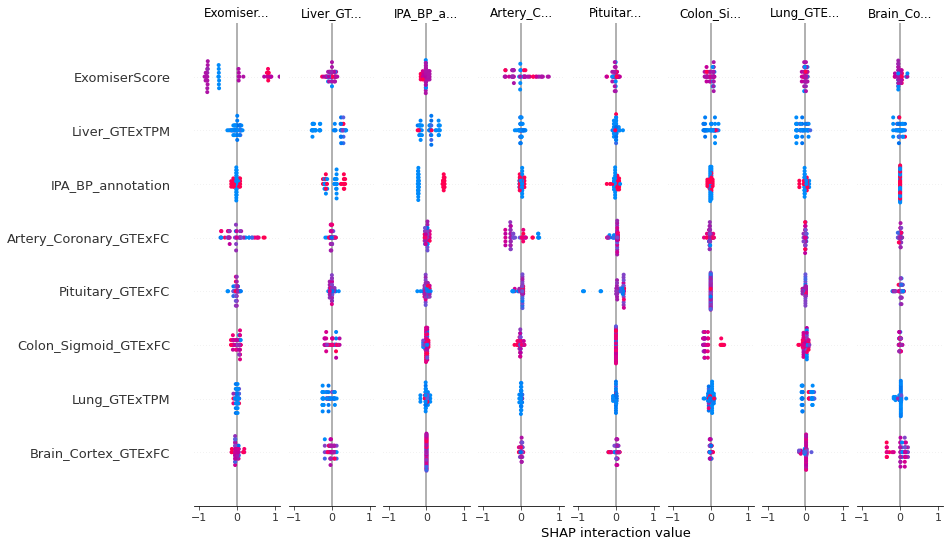

In [28]:
shap_interaction_values = shap.TreeExplainer(xgb).shap_interaction_values(X_test)
shap.summary_plot(shap_interaction_values, X_test, max_display=11)

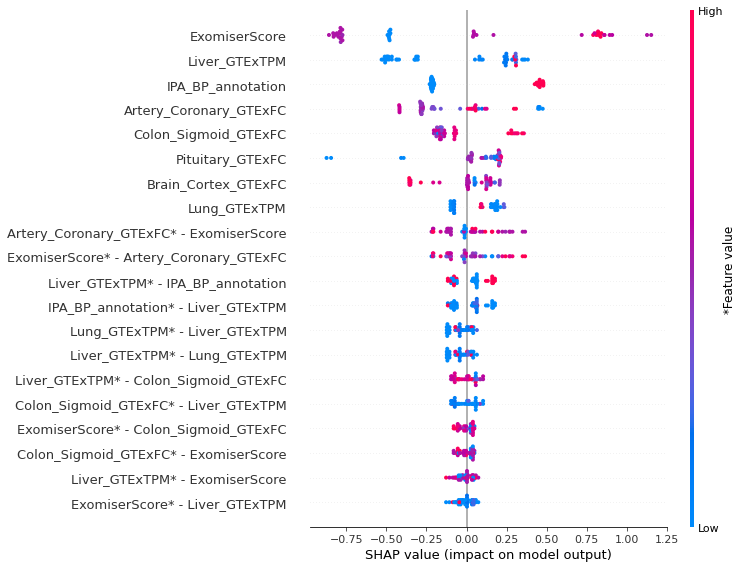

In [29]:
shap.summary_plot(shap_interaction_values, X_test, max_display=20, plot_type="compact_dot")

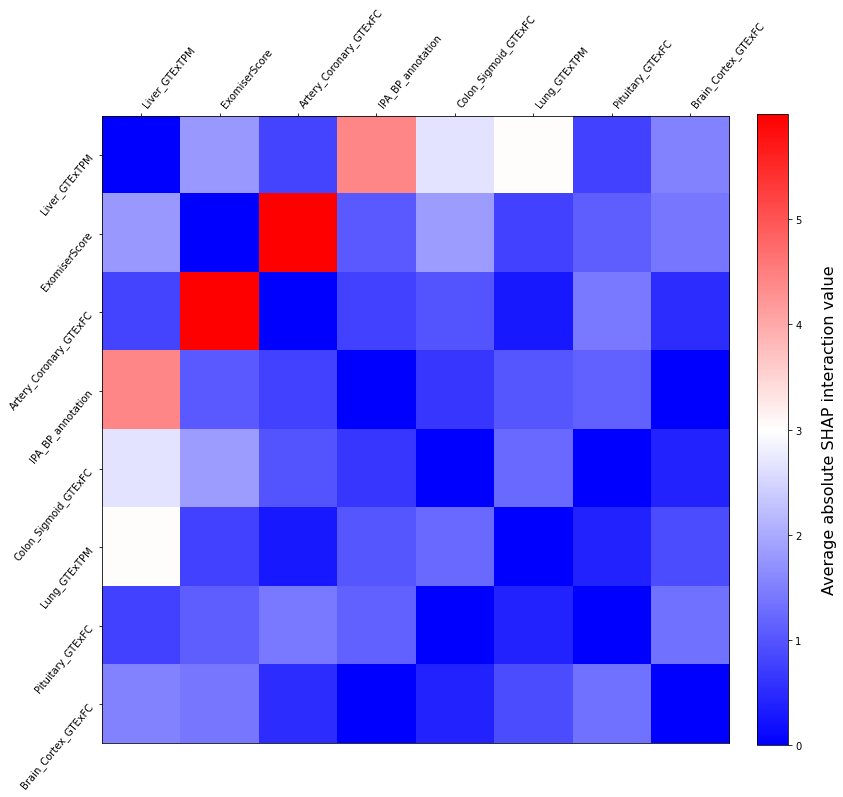

In [30]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds, :][:, inds]


f = plt.figure(figsize=(12, 12))
plt.imshow(
    tmp2, cmap="bwr"
)  
plt.yticks(
    range(tmp2.shape[0]),
    X_test.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(tmp2.shape[0]),
    X_test.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("Average absolute SHAP interaction value", size=16, labelpad=20)
plt.rcParams.update({"font.size": 16})
plt.tight_layout()
#f.savefig("shap_interactions.svg", format='svg', dpi=1200)


# 3. Supervised Learning - Multilabel Classification <a class="anchor" id="multilabel"></a>


In [31]:
#reading in target column/dependent variable (Y) and Gene names (row names) only:
data = pd.read_csv("training_cleaned.csv", header=0, usecols=["Gene","BPlabel"])

#Mapping labels to numeric values for supervised learning:
data["BPlabel_encoded"] = data["BPlabel"].map({"most likely": 0, "probable": 1, "least likely": 2})
Y = data["BPlabel_encoded"]

#reading in selected features:
X = pd.read_csv("selected_features_training_data.csv", header=0)

#Attach Gene column from data as row names:
df_gene = data[["Gene"]]
X = pd.concat([df_gene, X], axis=1)
X = X.set_index("Gene")

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

#Build model (Already tuned on nested cross-validation)
xgb = xgboost.XGBClassifier(
    n_estimators=46,
    learning_rate=0.1537131375248144,
    max_depth=3,
    reg_alpha=1,
    reg_lambda=1,
    random_state=seed,
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=3)

#Fit model to training data to investigate its performance when generlaising to unseen test data
xgb.fit(X_train, Y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1537131375248144,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=46, n_jobs=16,
              num_class=3, num_parallel_tree=1, objective='multi:softprob',
              random_state=42, reg_alpha=1, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

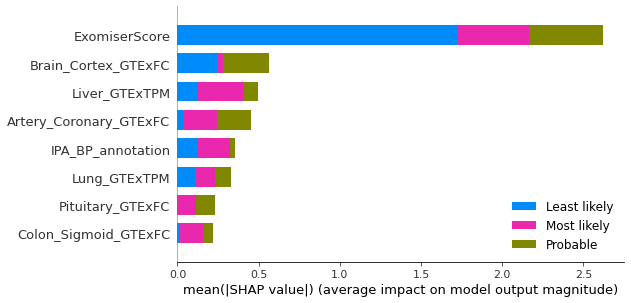

In [32]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
class_names = ["Most likely", "Probable", "Least likely"]
shap.summary_plot(shap_values, X_test, class_names=class_names)
#Multiclass only has bar plot type supported when viewing all classes

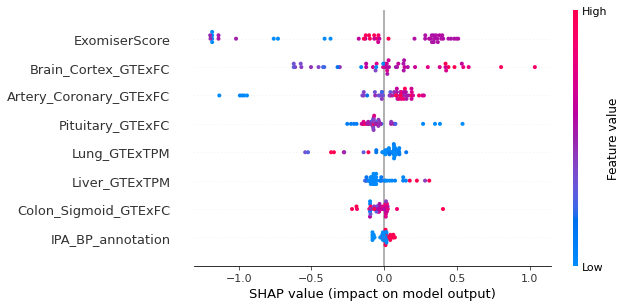

In [33]:
#Individual classs summary plot (change between 0-2 for each of the 3 classes):
shap.summary_plot(shap_values[1], X_test)

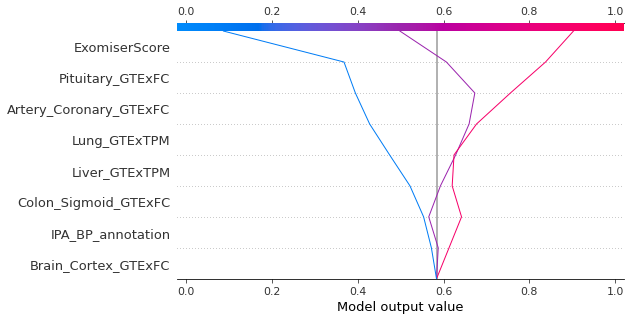

In [34]:
#Features for ACE (row 6) are used to calculate it's model's output prediction for the 3 groupings
shap.multioutput_decision_plot(explainer.expected_value, explainer.shap_values(X_test), row_index=6, feature_names=list(X), link='logit')

# 4. Regression Analysis <a class="anchor" id="regression"></a>

- Most plots are coded similarly to binary classification (but regression has more options defined for decision plots in SHAP documentation)

In [35]:
#Re-mapping labels to numeric values for regression analysis on scale 0-1:
data["BPlabel_encoded"] = data["BPlabel"].map({"most likely": 1, "probable": 0.75, "least likely": 0.1})
Y = data["BPlabel_encoded"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

#Build model (Already tuned on nested cross-validation)
xgb = xgboost.XGBRegressor(
    n_estimators=46,
    learning_rate=0.1537131375248144,
    max_depth=3,
    reg_alpha=1,
    reg_lambda=1,
    random_state=seed,
    objective="reg:squarederror")

#Fit model to training data to investigate its performance when generlaising to unseen test data
xgb.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1537131375248144, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=46, n_jobs=16, num_parallel_tree=1, random_state=42,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

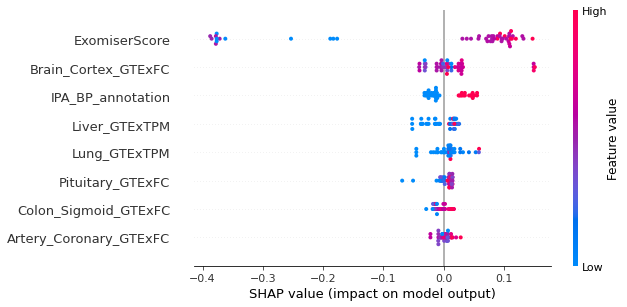

In [36]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
#beeswarm summary plot:
shap.summary_plot(shap_values, X_test)

In [37]:
explainer = shap.TreeExplainer(xgb)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(8)
features = X_test.iloc[select]
features_display = X_test.loc[features.index]

#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
shap_values = explainer.shap_values(features)[1]
shap_interaction_values = explainer.shap_interaction_values(features)
#if isinstance(shap_interaction_values, list):
shap_interaction_values = shap_interaction_values[1]

Explainer expected value: [0.67636184]


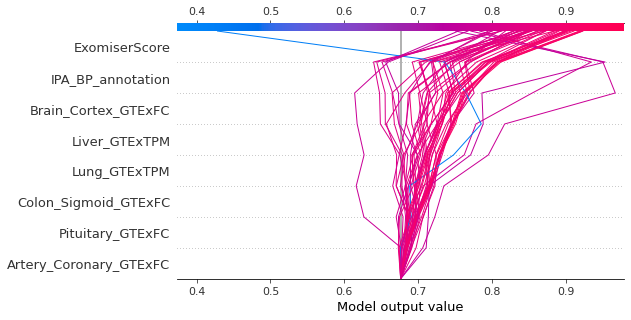

In [40]:
#Plot a group of genes by their assigned score (and view model's prediction of that score)
X.reset_index(drop=True, inplace=True)
T = X
T = T[(Y == 1)]

#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
sh = explainer.shap_values(T)

shap.decision_plot(expected_value, sh, T, return_objects=True)


Boolean Series key will be reindexed to match DataFrame index.


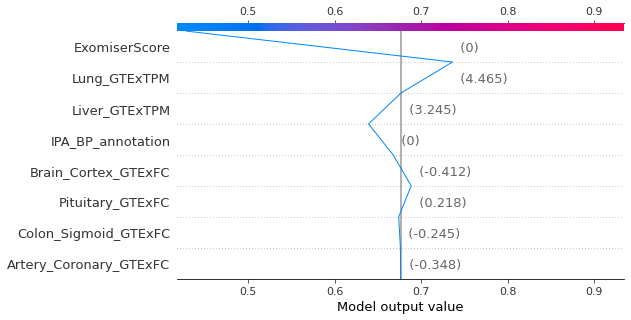

In [41]:
#Focus in on the one blue line that is having a low model output value
y_pred = xgb.predict(X)
T = X[(y_pred <= 0.6)]
T = T[(Y == 1)]
sh = explainer.shap_values(T)

r = shap.decision_plot(expected_value, sh, T, return_objects=True)

# 5. Average shapely values <a class="anchor" id="averages"></a>
- Averages calculated per each row in X and added as a column

In [42]:
xgb.fit(X,Y)
explainer = shap.Explainer(xgb, X)
shap_values = explainer.shap_values(X)
features = X.columns.values.tolist()

shapdf = pd.DataFrame(data=np.array(shap_values), columns=features)
shapdf["shap_average"] = shapdf.mean(axis=1) 
shapdf["model_pred"] = shapdf.mean(axis=1) + expected_value
shapdf

#index number can then be corresponded with shap_values variable index numbers to align where genes are clustered in shap's heatmap or interactive forceplot

,Pituitary_GTExFC,Lung_GTExTPM,Liver_GTExTPM,IPA_BP_annotation,ExomiserScore,Brain_Cortex_GTExFC,Artery_Coronary_GTExFC,Colon_Sigmoid_GTExFC,shap_average,model_pred
0,0.023752,0.004421,0.025582,0.063061,0.087226,0.013055,0.017678,0.020209,0.031873,0.708235
1,0.021714,-0.020186,-0.086376,-0.026205,-0.324843,-0.037793,-0.045436,-0.013807,-0.066616,0.609746
2,-0.036854,-0.003880,0.048736,-0.033538,-0.263273,-0.050986,-0.002428,-0.041568,-0.047974,0.628388
3,-0.036854,-0.003880,0.031209,-0.033267,-0.320570,-0.050986,-0.004721,-0.041870,-0.057618,0.618744
4,-0.023186,-0.016730,-0.075244,-0.026943,-0.341449,-0.028893,-0.031217,-0.009960,-0.069203,0.607159
...,...,...,...,...,...,...,...,...,...,...
238,0.016319,0.018644,0.024854,-0.012546,0.090102,-0.012051,0.011801,0.007261,0.018048,0.694410
239,-0.052614,0.003771,-0.011878,0.052017,0.128928,0.000997,-0.008761,0.008124,0.015073,0.691435
240,-0.010795,0.013765,0.016782,0.059571,0.107124,0.008743,0.009210,0.014609,0.027376,0.703738
241,0.018132,0.001547,0.023219,-0.012300,0.097086,0.018936,0.010058,0.007497,0.020522,0.696884


# 6. Additional shap plots <a class="anchor" id="custom"></a>

- Plots and configurations that work with different levels of sucess (work in progress)
    - Clustered bar plots
    - Dendrograms
    - Subplot configurations
    - Interactive SHAP plots

### Clustered bar plots:

In [43]:
# Supervised binary model

#reading in target column/dependent variable (Y) and Gene names (row names) only:
data = pd.read_csv("training_cleaned.csv", header=0, usecols=["Gene","BPlabel"])

#Mapping labels to numeric values for supervised learning:
data["BPlabel_encoded"] = data["BPlabel"].map({"most likely": 1, "probable": 0, "least likely": 0})
Y = data["BPlabel_encoded"]

#reading in selected features:
X = pd.read_csv("selected_features_training_data.csv", header=0)

#Attach Gene column from data as row names:
df_gene = data[["Gene"]]
X = pd.concat([df_gene, X], axis=1)
X = X.set_index("Gene")

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

#Build model (Already tuned on nested cross-validation)
xgb = xgboost.XGBClassifier(
    n_estimators=46,
    learning_rate=0.1537131375248144,
    max_depth=3,
    reg_alpha=1,
    reg_lambda=1,
    random_state=seed,
    eval_metric="mlogloss",
    use_label_encoder=False)

#Fit model to training data to investigate its performance when generlaising to unseen test data
xgb.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1537131375248144,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=46, n_jobs=16,
              num_parallel_tree=1, random_state=42, reg_alpha=1, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [44]:
X

,Pituitary_GTExFC,Lung_GTExTPM,Liver_GTExTPM,IPA_BP_annotation,ExomiserScore,Brain_Cortex_GTExFC,Artery_Coronary_GTExFC,Colon_Sigmoid_GTExFC
Gene,,,,,,,,
ABCC9,0.568715,6.558820,8.690460,1,0.884429,0.250539,0.429516,0.667657
AC020983.5,0.269346,0.000000,0.000000,0,0.206150,-1.013877,-0.517040,-2.517628
AC093677.1,-0.018310,46.132864,17.124436,0,0.459725,-0.020896,-0.001752,-0.054047
AC097374.4,0.002345,44.647068,18.070505,0,0.493107,0.001163,0.002153,-0.064376
AC103563.2,-0.611652,0.000000,0.000000,0,0.229406,-0.803294,-1.565081,-2.495896
...,...,...,...,...,...,...,...,...
VAMP2,0.128110,112.241000,24.538700,0,0.501797,-0.156217,-0.120251,0.071066
VDR,-1.157770,12.366400,0.334088,1,0.959359,-0.487937,1.536193,-0.541575
VEGFA,-0.636555,158.588000,143.583000,1,0.528332,1.749947,0.558394,-1.062173


In [45]:
#https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html
model = xgboost.XGBClassifier().fit(X, Y)
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

clustering = shap.utils.hclust(X, Y)

def f(x):
    return model.predict(X, output_margin=True)

# define a partition masker that uses our clustering
masker = shap.maskers.Partition(X, clustering=clustering)

# explain the model again
explainer = shap.Explainer(f, masker)

#final line below outputs error (work in progress to fix):
#shap_values_partition = explainer(X)
#AssertionError: The model produced 243 output rows when given 5046 input rows! Check the implementation of the model you provided for errors.
#shap.plots.bar(shap_values_partition[0], cluster_threshold=2)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:52:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### SHAP dendograms:

In [46]:
#Regression model
data = pd.read_csv("training_cleaned.csv", header=0, usecols=["Gene","BPlabel"])

#Re-mapping labels to numeric values for regression analysis on scale 0-1:
data["BPlabel_encoded"] = data["BPlabel"].map({"most likely": 1, "probable": 0.75, "least likely": 0.1})
Y = data["BPlabel_encoded"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

#Build model (Already tuned on nested cross-validation)
xgb = xgboost.XGBRegressor(
    n_estimators=46,
    learning_rate=0.1537131375248144,
    max_depth=3,
    reg_alpha=1,
    reg_lambda=1,
    random_state=seed,
    objective="reg:squarederror")

#Fit model to training data to investigate its performance when generlaising to unseen test data
xgb.fit(X, Y)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)


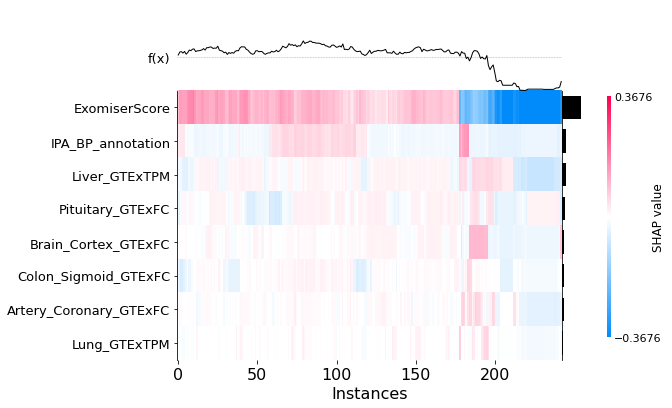

In [47]:
#Exploring the clustering of shap's heatmap 
shap_values = explainer(X)
shap.plots.heatmap(shap_values)

In [48]:
# Instance 0 along x-axis of heatmap above is number 72 in clustOrder array below
import scipy.cluster
from scipy.cluster import hierarchy
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage

D = scipy.spatial.distance.pdist(shap_values.values[:,:-1], 'sqeuclidean')
clustOrder = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.complete(D))
clustOrder

array([ 72,  80,  67,  11,  15,   6,  26, 111,  28, 138,   8,  10, 141,
       240,  65, 129, 213, 127, 217,  16, 223, 101, 219,  25,  29, 142,
       158, 230,   0,  84, 228, 104, 156, 162,  20, 124,  94, 164, 214,
       149, 173,  14, 236,  32, 234,  51, 134, 161, 211,  31, 212, 218,
        45, 108,  60,  12, 153, 184, 176, 232,  37, 216,  19, 215, 120,
        39,  76, 172, 179,  69, 235,  85,  13,  63, 165,  74, 182,  71,
       109, 154,  24, 155, 150, 131, 237,  61,  62,  70,  33, 139, 144,
       222, 118, 143,   9, 103, 239,  86,  54, 132,  27,  42, 112, 159,
        83, 183,  57, 157,  56, 121, 114,  98,  82, 110, 207, 225, 163,
       233, 102, 107, 166, 116, 147, 113, 205, 168,  55,  34, 133, 105,
        17, 128, 206,  21,  81, 226,  78, 208, 242,  36, 136,  88, 125,
       137, 148,  18,  59, 119, 126,  79, 146,  30,  97,  58, 210,  64,
       209, 181, 227, 229, 171,  91, 241, 178, 238, 145, 177, 220,  87,
       170, 135,  35, 100, 169, 221, 106,  43, 180, 197, 196, 11

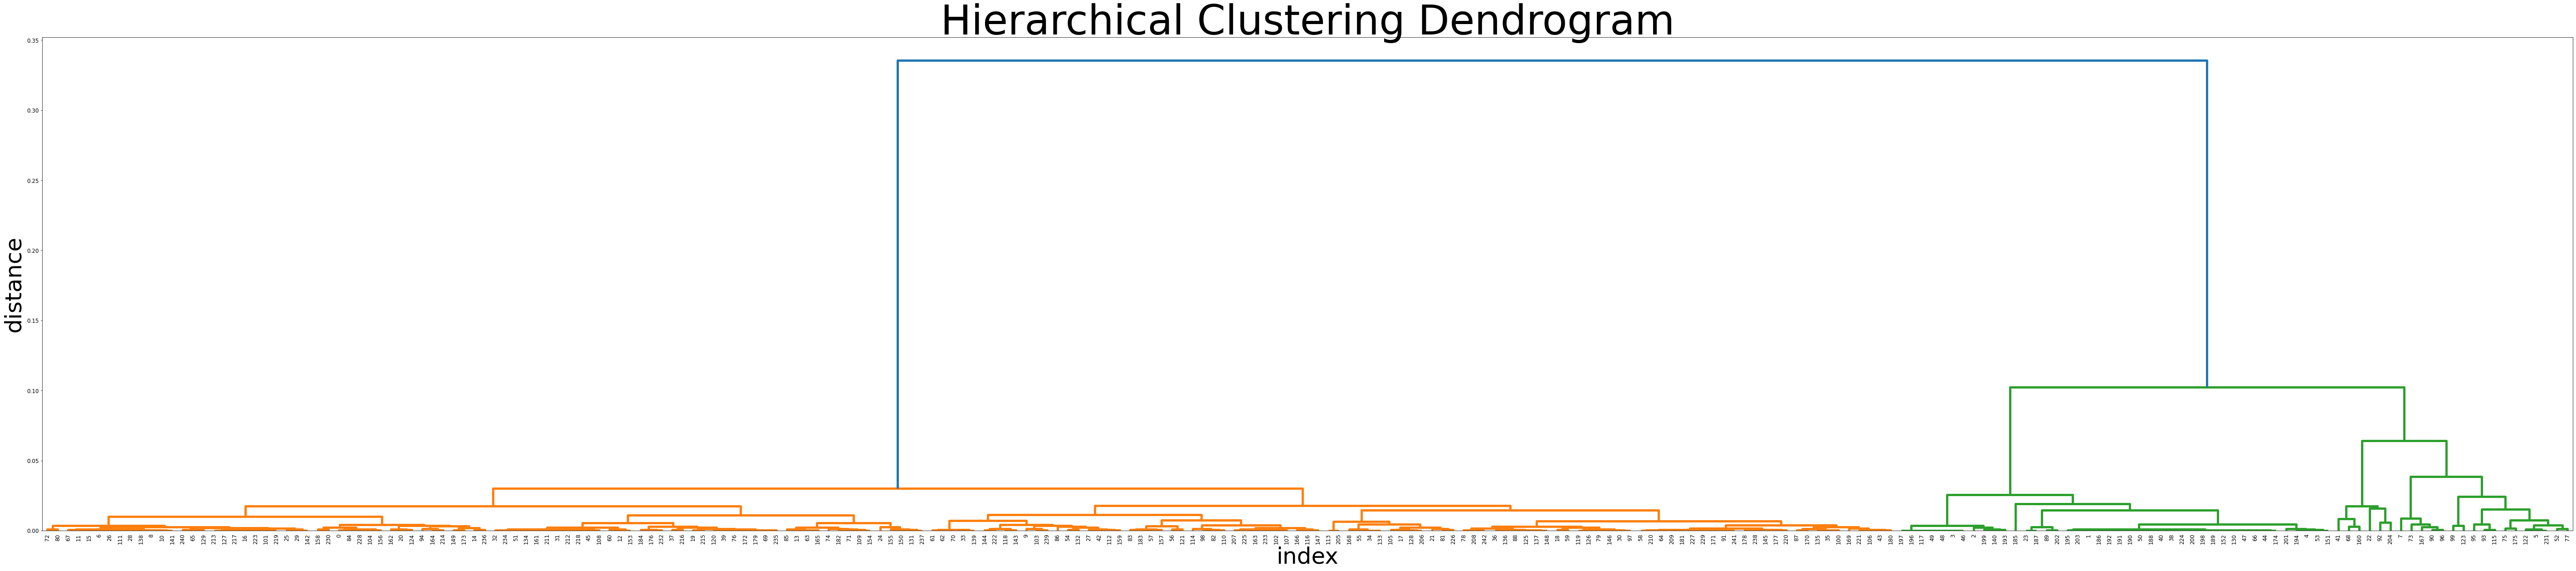

In [49]:
ordered = scipy.cluster.hierarchy.complete(D)

matplotlib.rcParams["lines.linewidth"] = 5
plt.figure(figsize=(100, 20))
plt.title("Hierarchical Clustering Dendrogram", fontsize=90)
plt.xlabel("index", fontsize=50)
plt.ylabel("distance", fontsize=50)
dendrogram(
    ordered,
    leaf_rotation=90.0,  # rotates the x axis labels
    leaf_font_size=8.0,  # font size for the x axis labels
)
plt.tick_params(labelsize=12)

#plt.savefig("shap_dendogram.tiff", dpi=300)
plt.show()

In [50]:
#Building table for interactive dendrogram
explainer = shap.Explainer(xgb, X)
shap_values = explainer.shap_values(X)
features = X.columns

predictions = list(xgb.predict(X))
output = pd.Series(data=predictions, index=X.index, name="XGB_Score")
output = output.to_frame()
output.reset_index(level=0, inplace=True)

df_a = data[["BPlabel_encoded"]]
df_b = pd.concat([output, df_a], axis=1)

shapdf = pd.DataFrame(data=np.array(shap_values), columns=features)
shapdf["shap_average"] = shapdf.mean(axis=1)
df_c = pd.concat([df_b, shapdf], axis=1)
df_d = df_c[["Gene", "XGB_Score", "shap_average", "BPlabel_encoded"]]
clusters = df_d.iloc[clustOrder]

In [51]:
gene_list = clusters["Gene"].tolist()
clusters = clusters.round(decimals=3)
clusters["index"] = clusters.index
clusters["title1"] = "XGB_Score:"
clusters["title2"] = "Training_Score:"
clusters["title3"] = "Gene:"

clusters2 = clusters[
    ["title3", "Gene", "title1", "XGB_Score", "title2", "BPlabel_encoded", "index"]
]

info = clusters2[clusters2.columns[0:]].apply(
    lambda x: ",".join(x.dropna().astype(str)), axis=1
)

info = info.tolist()
info = [s.replace(":,", ": ") for s in info]
info = [s.replace(",", ", ") for s in info]

In [52]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.figure_factory as FF
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash

figure = FF.create_dendrogram(
    ordered,
    orientation="bottom",
    hovertext=info,
    linkagefun=lambda x: scipy.cluster.hierarchy.complete(D),
)

explainer = shap.Explainer(xgb, X)
shap_values = explainer(X)
D = scipy.spatial.distance.pdist(shap_values.values[:, :-1], "sqeuclidean")
clustOrder = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.complete(D))
ordered = scipy.cluster.hierarchy.complete(D)

scipy.cluster.hierarchy.complete(
    scipy.spatial.distance.pdist(shap_values.values[:, :-1], "sqeuclidean")
)

figure.update_layout({"width": 1500, "height": 750}, font=dict(size=12))

figure.update_xaxes(visible=False, showticklabels=False)

figure.write_html("interactive_shap_dendogram.html")


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`


### Plot configurations and correlation heatmapping:

In [53]:
# identifying row numbers of genes of interest
print(list(X.index).index("NPPB"))
list(X.index).index("NPPA")

142


141

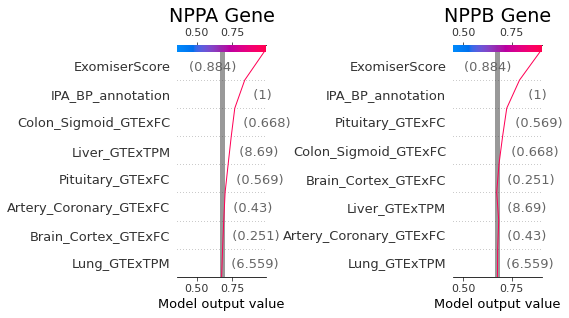

In [54]:
#https://towardsdatascience.com/four-custom-shap-plots-8605d73b4570
#https://github.com/conorosully/medium-articles/blob/master/src/shap_custom.ipynb

# Selecting plots to subplot by genes of interest
fig = plt.figure(figsize=(20,5))

ax1 = fig.add_subplot(121)
shap_values = explainer.shap_values(X)[141]
shap.decision_plot(expected_value, shap_values, X, show=False)
ax1.title.set_text('NPPA Gene')

ax2 = fig.add_subplot(122)
shap_values = explainer.shap_values(X)[142]
shap.decision_plot(expected_value, shap_values, X, show=False)
ax2.title.set_text('NPPB Gene')
plt.tight_layout()
plt.show()

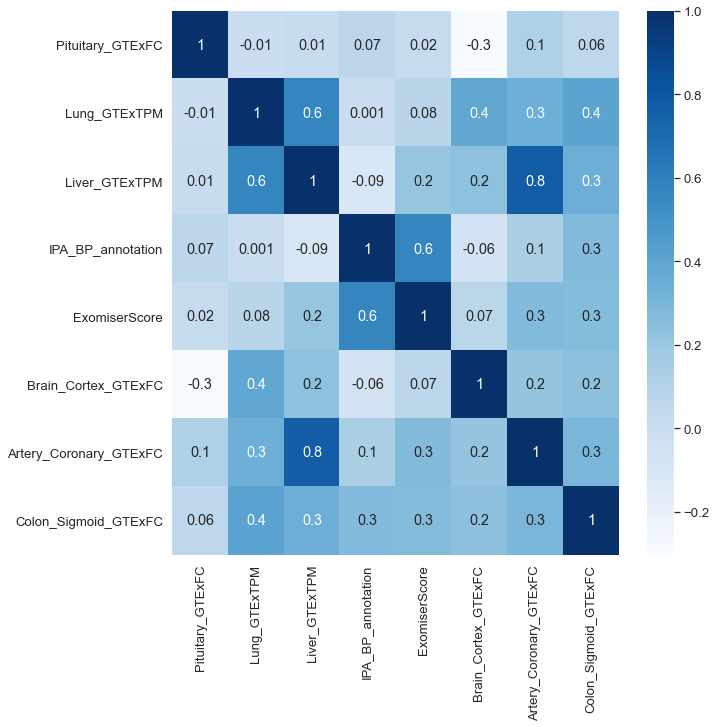

In [55]:
xgb.fit(X, Y)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

corr_matrix = pd.DataFrame(shap_values,columns=X.columns).corr()

# Display Correlations
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
sns.heatmap(corr_matrix,cmap='Blues',annot=True,fmt='.1g')

#plt.savefig(path.format('shap_correlation.png'),dpi=200,bbox_inches='tight')

# 7. GitHub repositories for interactive SHAP plots and GitHub repository references: <a class="anchor" id="interactive"></a>
- https://github.com/PrashantSaikia/Dynamic-SHAP-Plots 
- https://github.com/balajissp/dash-shap-components

Other GitHub repositories used:
- https://github.com/conorosully/medium-articles/blob/master/src/shap_custom.ipynb